<h1>Clustering alternative techniques</h1>

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from minisom import MiniSom
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Patch
import plotly.express as px
from sklearn.cluster import KMeans
from kneed import KneeLocator
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/content/drive/MyDrive/spotify top tracks/data/final_spotify_tracks.csv')
data.set_index('title', inplace=True)
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,POP,3.693075,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,Eminem,HIPHOP,44.814807,94.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,Kesha,POP,6.410236,81.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,Lady Gaga,POP,17.680180,89.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,Bruno Mars,POP,31.020064,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


In [3]:
genres = data['top genre']

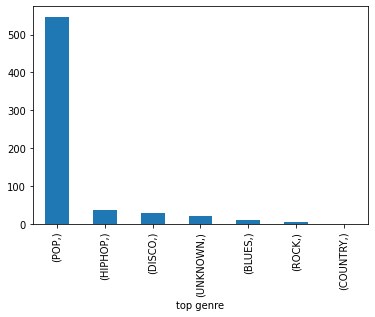

In [4]:
data[['top genre']].value_counts().plot.bar()
plt.show()

Most of the songs belong to the pop genre. Of the other genres, hip hop and disco are more frequent, but generally the other genres are present in about than 100 songs of 630.

Since the self organizing maps use Euclidean distance and Gaussian mixture models assume a multivariate normal distribution, only the continuous features will be used for clustering.

In [5]:
data.drop(['artist', 'top genre', 'year'], axis=1, inplace=True)

In [6]:
data = data.fillna(data.median())

In [7]:
data_not_scaled = data.copy(deep=True)

In [8]:
scaler  = StandardScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])
data.head()

,followers,artist_popularity,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,
"Hey, Soul Sister",-0.821657,-0.756502,-0.894579,1.180111,0.148635,0.872966,-0.737832,1.227401,-0.166341,0.176541,-0.589843,1.054889
Love The Way You Lie,1.711836,1.254668,-1.304649,1.426971,0.754609,0.307914,2.526270,0.511658,1.158459,0.409739,1.803688,0.985591
TiK ToK,-0.654254,-0.379408,0.048585,0.871535,0.830356,1.438017,0.820035,0.824796,-0.655940,-0.243214,0.669910,0.846994
Bad Romance,0.040083,0.626177,0.007577,1.365256,0.375876,0.872966,-0.737832,0.824796,2.080059,-0.709610,-0.589843,0.777695
Just the Way You Are,0.861947,1.128970,-0.402493,0.871535,-0.078605,0.307914,-0.663648,-0.427754,-0.051141,-0.616331,-0.589843,0.708397


Scaling the features to not affect the distance metric very much.

In [9]:
genres = genres.values

In [10]:
np.unique(genres)

array(['BLUES', 'COUNTRY', 'DISCO', 'HIPHOP', 'POP', 'ROCK', 'UNKNOWN'],
      dtype=object)

In [11]:
category_color = {'BLUES': 'darkgreen',
                  'COUNTRY': 'orange',
                  'DISCO': 'red',
                  'HIPHOP': 'blue',
                  'POP': 'purple',
                  'ROCK': 'black',
                  'UNKNOWN': 'grey'}

<h3>Self organizing maps</h3>

In [12]:
feature_names = data.columns

som_size = 25
som = MiniSom(som_size, som_size, len(data.columns),
              neighborhood_function='gaussian', sigma=1.5,
              random_seed=1)

som.pca_weights_init(data.values)
som.train_random(data.values, 5000, verbose=True)

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 1.0348158342349534


In [13]:
tracks_map = som.labels_map(data.values, data.index.values)

In [14]:
track_names = data.index

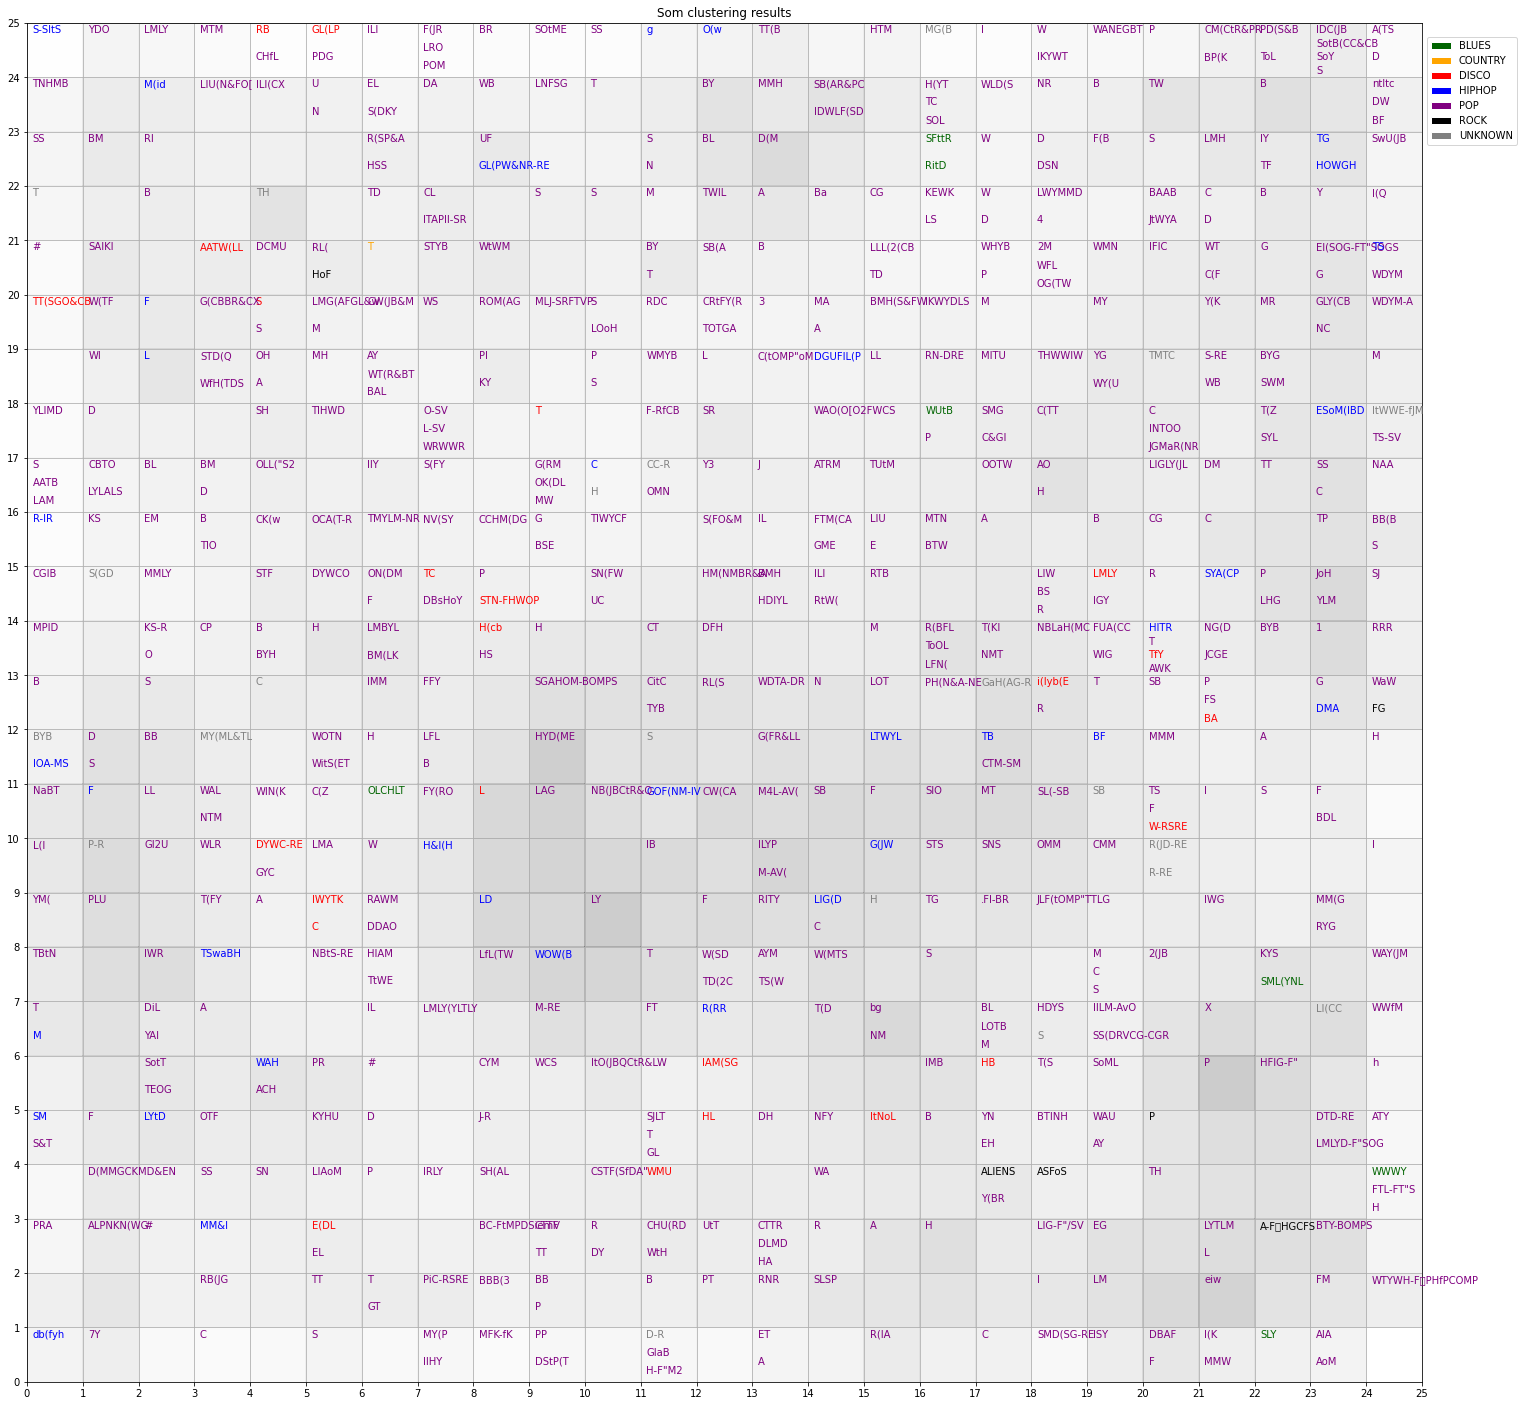

In [15]:
fig = plt.figure(figsize=(25, 25))
short_names_map = {}
for p, tracks in tracks_map.items():
    tracks = list(tracks)
    x = p[0] + .1
    y = p[1] - .3
    for i, t in enumerate(tracks):
        off_set = (i+1)/len(tracks) + 0.12
        name_idx = track_names.get_loc(t)
        #print(name_idx)
        if type(name_idx) != int:
          if name_idx[0] == True or name_idx[0] == False:
            name_idx = np.where(track_names.get_loc('Just the Way You Are'))[0][0]
          else:
            name_idx = name_idx[0]
        t = t.replace('$', 'S', -1)
        sn = t.split(' ')
        sn = [word[0] for word in sn]
        sn = ''.join(sn)
        short_names_map[sn] = t
        plt.text(x, y+off_set, sn, color=category_color[genres[name_idx]], fontsize=10)
plt.pcolor(som.distance_map().T, cmap='gray_r', alpha=.2)
plt.xticks(np.arange(som_size+1))
plt.yticks(np.arange(som_size+1))
plt.grid()

legend_elements = [Patch(facecolor=clr,
                         edgecolor='w',
                         label=l) for l, clr in category_color.items()]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, .95))
plt.title('Som clustering results')
plt.show()

In [16]:
short_names_map

{'#': '#SELFIE',
 '.FI-BR': '...Ready For It? - BloodPop® Remix',
 '1': '1+1',
 '2(JB': '2U (feat. Justin Bieber)',
 '2M': '24K Magic',
 '3': '3',
 '4': '43776',
 '7Y': '7 Years',
 'A': 'Anywhere',
 'A(TS': 'Antisocial (with Travis Scott)',
 'A-F\x93HGCFS': 'Atlas - From \x93The Hunger Games: Catching Fire\x94 Soundtrack',
 'AATB': 'All About That Bass',
 'AATW(LL': 'All Around The World (La La La)',
 'ACH': 'Anything Could Happen',
 'AIA': 'All I Ask',
 'ALIENS': 'A L I E N S',
 'ALPNKN(WG': 'A Little Party Never Killed Nobody (All We Got)',
 'AO': 'American Oxygen',
 'ASFoS': 'A Sky Full of Stars',
 'ATRM': 'All The Right Moves',
 'ATY': 'A Thousand Years',
 'AWK': 'All We Know',
 'AY': 'Adore You',
 'AYM': "Ain't Your Mama",
 'AoM': 'All of Me',
 'B': 'BURNITUP!',
 'BA': 'Broken Arrows',
 'BAAB': 'Beauty And A Beat',
 'BAL': 'Bad At Love',
 'BB': 'Boom Boom',
 'BB(B': 'Beautiful Birds (feat. Birdy)',
 'BBB(3': 'Blah Blah Blah (feat. 3OH!3)',
 'BC-FtMPDSiemV': 'Boom Clap - From the M

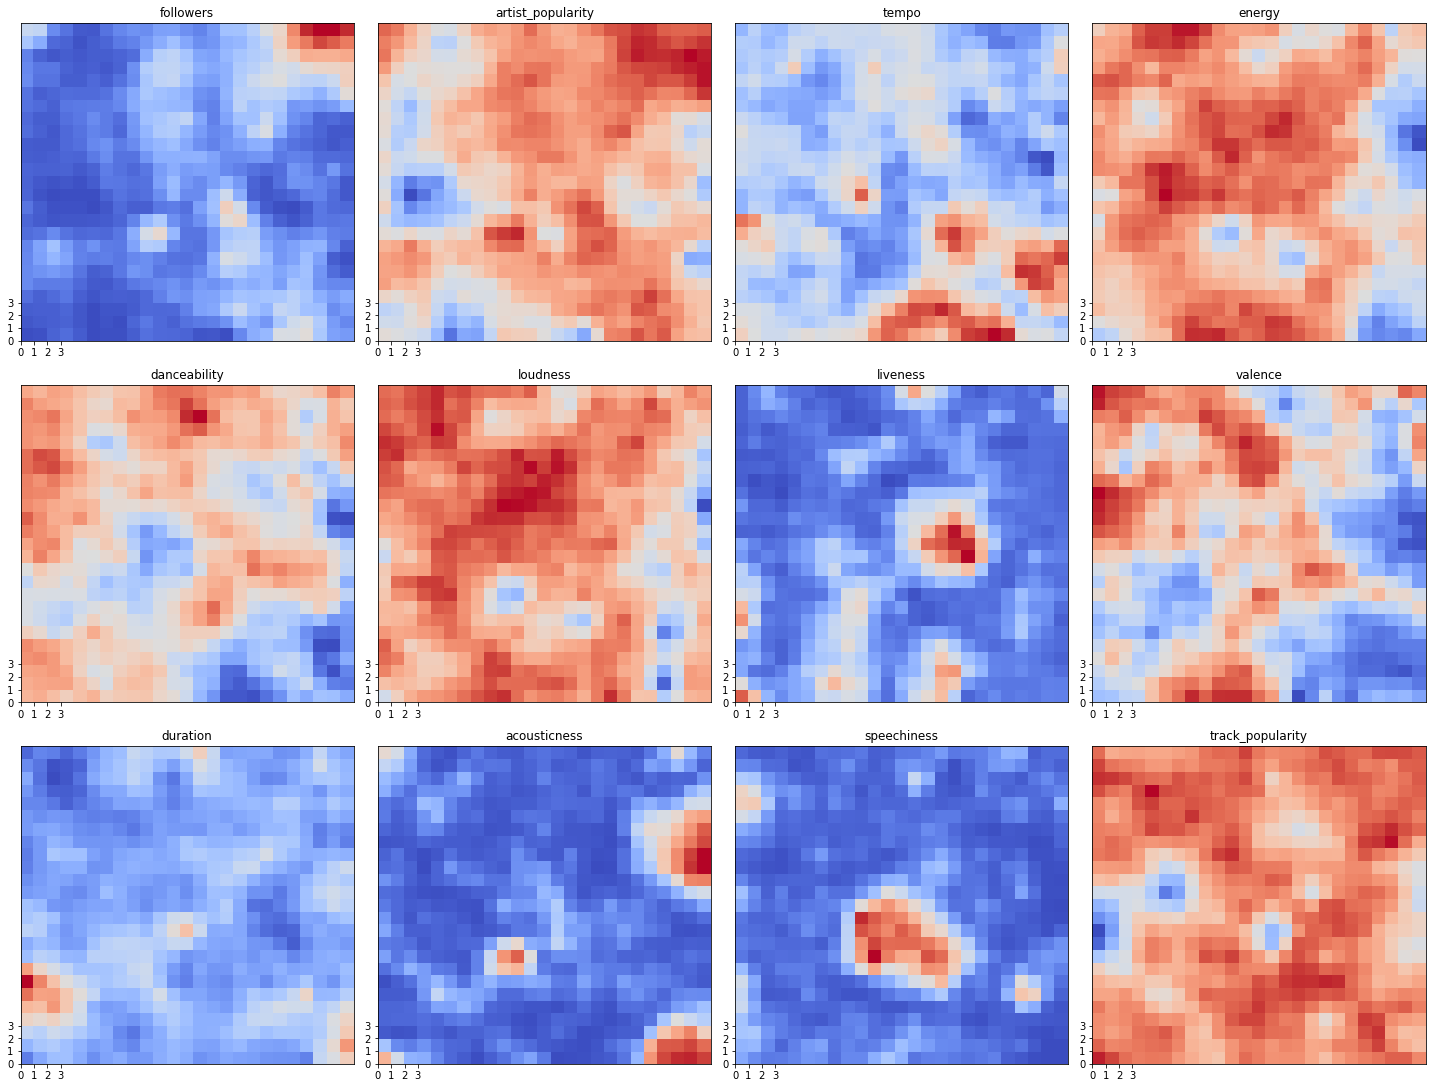

In [17]:
import math
W = som.get_weights()
size_plot = math.sqrt(len(feature_names))
size_plot = math.floor(size_plot)
plt.figure(figsize=(20, 20))
for i, f in enumerate(feature_names):
    plt.subplot(size_plot+1, size_plot+1, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    plt.xticks(np.arange(size_plot+1))
    plt.yticks(np.arange(size_plot+1))
plt.tight_layout()
plt.show()

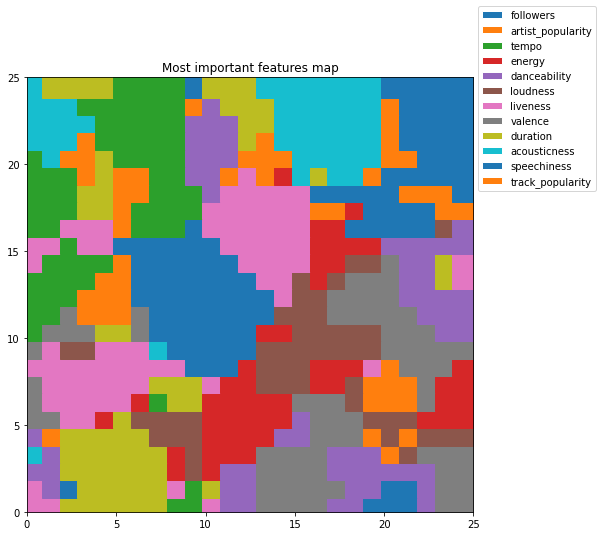

In [18]:
Z = np.zeros((som_size, som_size))
plt.figure(figsize=(8, 8))
for i in np.arange(som._weights.shape[0]):
    for j in np.arange(som._weights.shape[1]):
        feature = np.argmax(W[i, j , :])
        plt.plot([j+.5], [i+.5], 'o', color='C'+str(feature),
                 marker='s', markersize=24)

legend_elements = [Patch(facecolor='C'+str(i),
                         edgecolor='w',
                         label=f) for i, f in enumerate(feature_names)]

plt.legend(handles=legend_elements,
           loc='center left',
           bbox_to_anchor=(1, .95))
        
plt.xlim([0, som_size])
plt.ylim([0, som_size])
plt.title('Most important features map')
plt.show()

As we can see, different regions use diffrenet features to create the final result. In the top corners the strongest features are tempo and followers, and in the bottom corners, valence and duration are considered distinguishing. 
<br>
Althoug generally, the feature importance is non homogeneus in each region, and there are not very strong connected groups.

Since each output neuron resembles a separate centroid, I am going to use K-means on the output neuron weightsh to cluster them into close regions. First i will find the coordinates each sample is projected to via the som model and use these coordinates in place of the original values of the data. Then, using the elbow method I am going to select the best number of clusters.

In [19]:
winner_coordinates = np.array([som.winner(x) for x in data.values]).T
cluster_index = np.ravel_multi_index(winner_coordinates, (som_size, som_size))

In [20]:
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)

In [21]:
som_centroids = []
for x in data.values:
  xi, yi = som.winner(x)
  weights = som.get_weights()[xi][yi]
  som_centroids.append(weights)

In [22]:
num_clst = np.arange(3, 20)
inertia = []
models = []
for k in num_clst:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(som_centroids)
  models.append(kmeans)
  inertia.append(kmeans.inertia_)

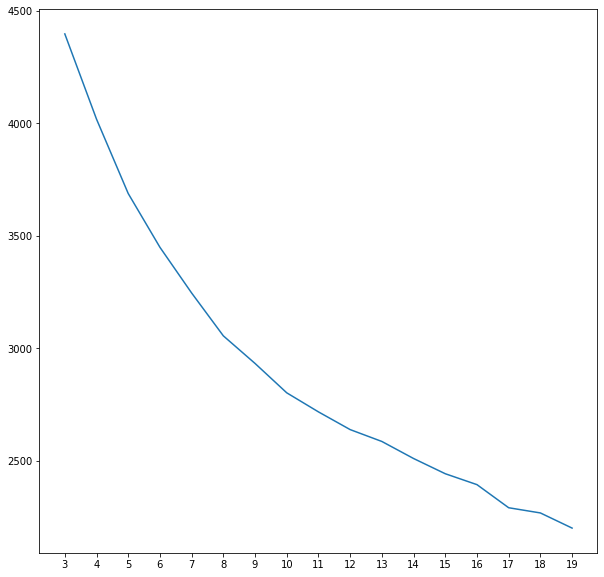

In [23]:
plt.figure(figsize=(10,10))
plt.plot(inertia)
plt.xticks(np.arange(len(num_clst)), num_clst)
plt.show()

In [24]:
knloc = KneeLocator(num_clst, inertia, curve="convex", direction="decreasing")

In [25]:
knloc.elbow

8

In [26]:
kmeans = KMeans(n_clusters=knloc.elbow)
kmeans.fit(som_centroids)
labels = kmeans.labels_

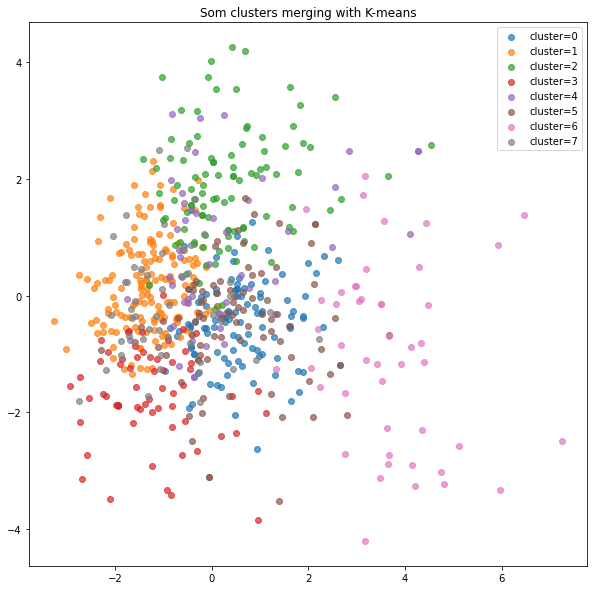

In [27]:
plt.figure(figsize=(10,10))
for c in np.unique(labels):
    plt.scatter(data_2d[labels == c, 0],
                data_2d[labels == c, 1], label='cluster='+str(c), alpha=.7)
plt.legend()
plt.title('Som clusters merging with K-means')
plt.show()

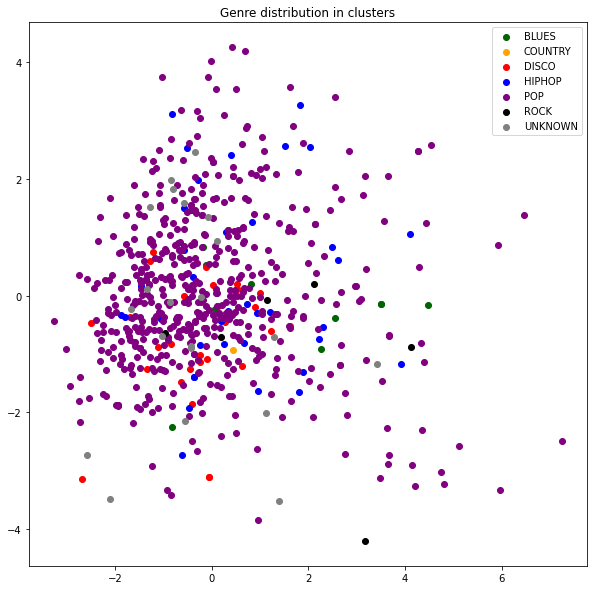

In [28]:
plt.figure(figsize=(10,10))
for gen in np.unique(genres):
  plt.scatter(data_2d[genres==gen, 0],
              data_2d[genres==gen, 1],
              color=category_color[gen], label=gen)
plt.title('Genre distribution in clusters')
plt.legend()
plt.show()

After combining the clusters using kmeans on the neurons each sample was assigned to, there were 8 clusters found in the data. Now k-means does not find just regular globular clusters. The clustering effect does capture some of the properites of the data.

Although the external genres are not quite well represented. The clustering seems to grasp different characteristics of tracks and groups them accordingly.

In [29]:
res = []
for c in np.unique(labels):
  node = {}
  subdata = data_not_scaled[labels == c]
  node['number of tracks'] = len(subdata)
  node['followers'] = np.median(subdata[['followers']].values)
  node['artist_popularity'] = np.median(subdata[['artist_popularity']].values)
  node['tempo'] = np.median(subdata[['tempo']].values)
  node['energy'] = np.median(subdata[['energy']].values)
  node['danceability'] = np.median(subdata[['danceability']].values)
  node['loudness'] = np.median(subdata[['loudness']].values)
  node['liveness'] = np.median(subdata[['liveness']].values)
  node['valence'] = np.median(subdata[['valence']].values)
  node['duration'] = np.median(subdata[['duration']].values)
  node['acousticness'] = np.median(subdata[['acousticness']].values)
  node['speechiness'] = np.median(subdata[['speechiness']].values)
  node['track_popularity'] = np.median(subdata[['track_popularity']].values)
  subgenres = genres[labels == c]
  for gen in np.unique(subgenres):
    node[gen] = len(np.where(subgenres==gen)[0])
  res.append(node)
res = pd.DataFrame(data=res)
res = res.fillna(0)
res

,number of tracks,followers,artist_popularity,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,BLUES,COUNTRY,DISCO,HIPHOP,POP,UNKNOWN,ROCK
0,105,7.826076,83.0,103.0,62.0,69.0,-7.000,12.0,42.0,224.0,6.0,5.00,72.0,1.0,1.0,9.0,10,80,4,0.0
1,155,8.652796,83.0,121.0,81.0,71.0,-4.000,11.0,71.0,211.0,5.0,5.00,72.0,0.0,0.0,9.0,7,133,5,1.0
2,100,40.244006,92.0,110.0,71.5,71.5,-6.000,11.0,56.0,220.0,5.0,5.75,74.0,3.0,0.0,0.0,4,92,1,0.0
3,62,2.644461,75.0,120.0,79.5,67.0,-5.000,18.0,57.5,216.0,4.0,6.00,46.0,1.0,0.0,2.0,2,53,4,0.0
4,49,16.505769,89.0,105.0,73.0,67.0,-6.000,15.0,59.0,217.0,11.0,29.00,70.0,0.0,0.0,0.0,8,38,3,0.0
5,84,16.287926,87.0,140.0,73.0,50.5,-5.467,12.0,30.0,231.5,5.0,5.99,69.5,2.0,0.0,8.0,1,68,2,3.0
6,47,7.950791,85.0,112.0,37.0,50.1,-7.000,11.0,23.0,227.0,75.0,3.00,71.0,3.0,0.0,0.0,1,40,1,2.0
7,50,9.622108,85.0,123.5,80.0,67.0,-5.000,42.5,63.5,222.5,4.0,9.00,70.0,0.0,0.0,1.0,5,43,1,0.0


Cluster 2 has artists with the largest number of followers by far where the median track popularity is also the largest, but not very significantly. Most of the songs are pop, although this cluster does not have the largest number of pop songs. The most live songs on average are in cluster 7 which contains 43 pop tracks and one disco track. On average, the least popular songs are in clsuter 3, where most of the songs are pop (expected), 1 blues, 2 disco, 2 hiphop and 4 from uncategorized genres.

<h3>Gaussian Mixture</h3>

In [30]:
mixtures = []
err_ratios = []
sil_coefs = []
covariances = ['full', 'tied', 'diag', 'spherical']
covs_app = []
number_of_clst = []
n_clst = [3, 4, 5, 6, 7, 8]
for num in n_clst:
  for cov in covariances:
    mix = GaussianMixture(n_components=num,covariance_type=cov, random_state=0)
    mix.fit(data)
    mixtures.append(mix)
    number_of_clst.append(num)
    covs_app.append(cov)
    sil_coefs.append(silhouette_score(data, mix.predict(data)))
    err_ratios.append(calinski_harabasz_score(data, mix.predict(data)))

In [31]:
mixture_results = pd.DataFrame({'Number of clusters': number_of_clst, 'Covariance': covs_app, 'Silhouette coefficient': sil_coefs,
             'Calinski Harabasz score': err_ratios})
mixture_results

,Number of clusters,Covariance,Silhouette coefficient,Calinski Harabasz score
0,3,full,0.074653,64.764695
1,3,tied,0.107586,80.461163
2,3,diag,0.062891,66.860875
3,3,spherical,0.050417,59.801630
4,4,full,0.057842,50.676328
5,4,tied,0.084339,58.649970
6,4,diag,0.081277,69.708806
7,4,spherical,0.078801,66.175330
8,5,full,0.017345,44.447510
9,5,tied,0.087862,57.822089


The best scores are acheived for 3 clusters with a tied covariance matrix.

In [32]:
mix = GaussianMixture(n_components=3,covariance_type='tied', random_state=0)
preds = mix.fit_predict(data)

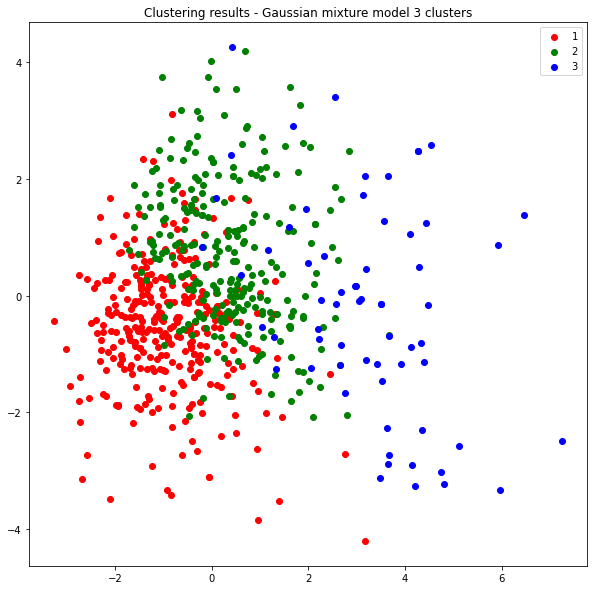

In [33]:
plt.figure(figsize=(10,10))
for label,c in zip(np.unique(preds), ['red', 'green', 'blue']):
  plt.scatter(data_2d[preds==label, 0],
              data_2d[preds==label, 1],
              color=c, label=str(label + 1))
plt.title('Clustering results - Gaussian mixture model 3 clusters')
plt.legend()
plt.show()

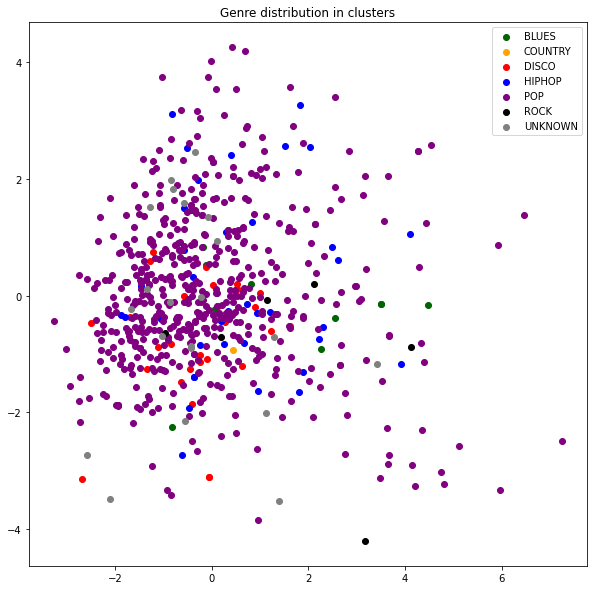

In [34]:
plt.figure(figsize=(10,10))
for gen in np.unique(genres):
  plt.scatter(data_2d[genres==gen, 0],
              data_2d[genres==gen, 1],
              color=category_color[gen], label=gen)
plt.title('Genre distribution in clusters')
plt.legend()
plt.show()

We can see that the genres are intertwined, no clustering algorithm can split them up in such a fasion. Other genres are particularly rare compared to pop, but there are still some differences in the subgenres of pop, that can be captured with the abowe clustering.

In [35]:
res = []
for c in np.unique(preds):
  node = {}
  subdata = data_not_scaled[preds == c]
  node['number of tracks'] = len(subdata)
  node['followers'] = np.median(subdata[['followers']].values)
  node['artist_popularity'] = np.median(subdata[['artist_popularity']].values)
  node['tempo'] = np.median(subdata[['tempo']].values)
  node['energy'] = np.median(subdata[['energy']].values)
  node['danceability'] = np.median(subdata[['danceability']].values)
  node['loudness'] = np.median(subdata[['loudness']].values)
  node['liveness'] = np.median(subdata[['liveness']].values)
  node['valence'] = np.median(subdata[['valence']].values)
  node['duration'] = np.median(subdata[['duration']].values)
  node['acousticness'] = np.median(subdata[['acousticness']].values)
  node['speechiness'] = np.median(subdata[['speechiness']].values)
  node['track_popularity'] = np.median(subdata[['track_popularity']].values)
  subgenres = genres[labels == c]
  for gen in np.unique(subgenres):
    node[gen] = len(np.where(subgenres==gen)[0])
  res.append(node)
res = pd.DataFrame(data=res)
res = res.fillna(0)
res

,number of tracks,followers,artist_popularity,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,BLUES,COUNTRY,DISCO,HIPHOP,POP,UNKNOWN,ROCK
0,322,6.420769,80.0,120.0000,77.00,69.0,-5.0,13.0,65.0,211.0,5.00,6.0,67.0,1.0,1.0,9.0,10,80,4,0.0
1,266,22.646855,89.0,120.0000,72.00,65.0,-6.0,12.0,44.0,227.0,5.00,5.0,73.0,0.0,0.0,9.0,7,133,5,1.0
2,64,17.139353,87.0,109.9455,40.75,56.5,-7.0,11.0,33.5,228.0,73.05,4.0,75.5,3.0,0.0,0.0,4,92,1,0.0


On average, the most popular songs are in cluster 2, although the difference with the other clusters is not very significant. Cluster 1 has the most pop songs in it and most songs that are uncategorized. The largest accousticness is in cluster 2. Cluster 0 is characterized wiht the largest danceability, on average, and the higest energy. Cluster 2 has te lowest energy on average.